In [87]:
import pandas as pd
from nbgwas import NBGWAS_snp2gene as snp2gene
from nbgwas import NBGWAS_propagation as prop
from nbgwas import NBGWAS_analysis
import numpy as np
import scipy.stats as stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Process Raw Data for Mapping P-Values to Genes

In [ ]:
f = open('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Lithium_Response/daner_pgbd_all_va_enterm_vf1.meta_good')
lines = f.read().splitlines()
lines_fmt = [line.split() for line in lines]
snp_table = pd.DataFrame(lines_fmt[1:], columns = lines_fmt[0])

In [25]:
# Format SNP table for usage of gene p-value assignment
snp_table_fmt = snp_table[['SNP', 'CHR', 'BP', 'P']]
snp_table_fmt.columns = ['Marker', 'Chr', 'Pos', 'P-Value']
snp_table_fmt[['Chr', 'Pos', 'P-Value']] = snp_table_fmt[['Chr', 'Pos', 'P-Value']].apply(pd.to_numeric)

# Map P-Value to Genes
Using minimum p method with a 10kb window around all genes
This data is mapped using genome build hg19, p-value ties are broken by gene distance to SNP

In [27]:
# Load hg19 gene locations (gene locations from VEGAS2 gencode file)
hg19_gene_pos_file = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/IGAP/SNP_Gene_Locations/glist-hg19_fmt.txt'
hg19_gene_pos = snp2gene.load_gene_pos(hg19_gene_pos_file, delimiter='\t', header=True, cols='0,1,2,3')

In [29]:
%%time
# Assign p-values to genes in hg19 using the minimum-p method with a 10kb window
min_p_table = snp2gene.min_p(snp_table_fmt, hg19_gene_pos, 10)
min_p_table_sort = min_p_table.sort_values(by=['TopSNP P-Value', 'SNP Distance'])
min_p_table_sort.to_csv('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Lithium_Response/daner_pgbd_all_va_enterm_vf1.meta_good.hg19_min_p_10kb.csv', sep='\t') 

CPU times: user 1h 13min 2s, sys: 1min 18s, total: 1h 14min 21s
Wall time: 1h 14min 21s


# Propagate Top 1% of Genes over PCNet

In [3]:
# Load PCNet
PCNet_fn = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Network_Data/PCNet.txt'
network, network_nodes, network_node_degree = prop.load_network(PCNet_fn)

Network File Loaded: 29.870319128 seconds
Number of network nodes: 19781
Number of network edges: 2724724


If you have loaded a pre-calculated kernel run the following cell:

In [4]:
# Load PCNet Kernel (assuming the kernel was saved in .hdf format by pandas)
kernel = pd.read_hdf('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Network_Data/PCNet_kernel.hdf')

Otherwise, if you do not have a pre-calculated kernel file, construct the network kernel using the following code:

In [ ]:
# Set the number of threads you want to use (otherwise all available threads on the machine will be used)
import mkl
mkl.set_num_threads(4)

# Construct the propagation kernel (set outdir to save the kernel to be used at a later time if desired)
kernel_outdir = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Network_Data/'
kernel = prop.construct_network_kernel(network, alpha=None, outdir=kernel_outdir)

In [5]:
# Load gene_pval_table (output from snp2gene.min_p)
pval_table_fn = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Lithium_Response/daner_pgbd_all_va_enterm_vf1.meta_good.hg19_min_p_10kb.csv'
gene_pval_table = pd.read_csv(pval_table_fn, sep='\t')

In [6]:
results_dir = '/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/Lithium_Response/'
thresh_prop_results, null_prop_results = prop.kernel_propagation(kernel, gene_pval_table, network_node_degree, 
                                                                 pct_thresh = 0.01, p_thresh = None, outdir = results_dir)

249 genes above threshold (Top 1.0%)
188 threshold genes in network as seeds
4 seed genes could not be swapped: [u'EFTUD2', u'MRPL15', u'HMGB1', u'NOC3L']
Seed genes propagated: 1.05010414124 seconds
Non-seed gene propagation results compiled
Seed gene propagation results compiled
Propagation results constructed and sorted
Propagation results saved: /cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/Lithium_Response/Top_1.0%_prop_results.csv
Non-seed gene propagation results compiled
Seed gene propagation results compiled
Propagation results constructed and sorted
Propagation results saved: /cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/Lithium_Response/Null_Seeds_prop_results.csv


# Evaluate the methods on a gold standard gene set
In this case, the lithium gene set was determined by compiling all human genes in any GO term (via AmiGO) that contains the word 'lithium'

In [13]:
# Lithium Gene Gold Standard
gold_stds = NBGWAS_analysis.load_GS_sets('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/Lithium_Response/Lithium_GO_genes.txt')
gold_std = gold_stds[gold_stds.keys()[0]]

In [24]:
# Calculate Precision Recall Curves and AUPRC for all network-based GWAS models
model_names = ['GWAS Only', 'Degree Only', 'TopProp Only', 'TopProp x GWAS', 'NullProp Only', 'NulProp x GWAS']
model_results = [thresh_prop_results.sort_values(by=['GWAS P-Value', 'GWAS SNP Dist']),
                 thresh_prop_results.ix[network_nodes].sort_values(by=['Degree', 'GWAS P-Value', 'GWAS SNP Dist'], 
                                                                   ascending=[False, True, True]),
                 thresh_prop_results.sort_values(by=['Prop Rank', 'GWAS P-Value', 'GWAS SNP Dist']),
                 thresh_prop_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value', 'GWAS SNP Dist']),
                 null_prop_results.sort_values(by=['Prop Rank', 'GWAS P-Value', 'GWAS SNP Dist']),
                 null_prop_results.sort_values(by=['Adjusted Rank', 'GWAS P-Value', 'GWAS SNP Dist'])]
model_AUPRCs = []
for i in range(len(model_names)):
    precision, recall, AUPRC = NBGWAS_analysis.PRC(model_results[i], gold_std)
    model_AUPRCs.append(AUPRC)

In [90]:
pd.Series(model_AUPRCs, index=model_names)

GWAS Only         0.018070
Degree Only       0.020342
TopProp Only      0.020445
TopProp x GWAS    0.019323
NullProp Only     0.019865
NulProp x GWAS    0.018699
dtype: float64

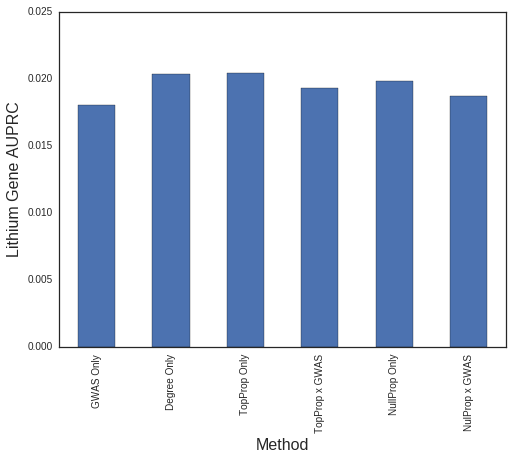

In [41]:
# Plot Model AUPRC results
plt.figure(figsize=(8,6))
pd.Series(model_AUPRCs, index=model_names).plot.bar()
plt.xlabel('Method', fontsize=16)
plt.ylabel('Lithium Gene AUPRC', fontsize=16)

In [93]:
# Construct a ranked gene list
ranked_gene_list = thresh_prop_results.sort_values(by=['Prop Rank', 
                                                       'GWAS P-Value', 
                                                       'GWAS SNP Dist']).reset_index(drop=False).reset_index()[['index', 'Gene']]
ranked_gene_list['index'] += 1
ranked_gene_list.columns = ['Rank', 'Gene']

In [102]:
# Calculate the ranksum statistic of a gold standard gene set from a ranked gene list
# Must pass a 2-column DataFrame with the columns "Rank" (indexed from 1), and "Gene"
ranksum_Z, ranksum_p = NBGWAS_analysis.ranksum(ranked_gene_list, gold_std)

Z-score and p-value of TopProp Only Rank Sum Test:
Z = -4.51877781482
p = 3.10988111896e-06
